## 1) Inspiration

This dataset contains information of protests against the state worldwide from 1990-2020. It combines data from three sources: the Mass Mobilization (MM) Dataset, Varieties of Democracy (V-Dem) Dataset, and the Human Development Index (HDI). The MM dataset contains data of year, country and region, protester demands, state responses, and whether violence occured at a particular protest. V-Dem is a comprehensive and widely-used dataset that measures various indices of democracy and governance, providing scores that measure the electoral, liberal, participatory, deliberative, and egalitarian scores of democracy for a country and year specific to a protest. HDI is a composite measure that ranks countries based on their level of human development. Together, these data can provide valuable insight to the nature of citizen movements against the state, and the how the demands of both interact in protests. Within the past 5 years, we have seen a global shift towards right-wing control, exemplified by the Trump administration in the U.S. and the rise of Germany's far-right AfD party, to name a few. In the U.S. in particular, censorship, repeals of progressive policies, and social unrest are at unprecendented levels in recent history. Thus, understanding the efficacy and nature of citizen protests is more relevant than ever. Furthermore, examining the complex relationships between democracy levels, protester demands, violence, region, year, and protest success may suggest the significance of certain predictors in the study of political unrest and violence on a larger scale.

## 2) Stakeholders


The main stakeholders of this project are those in the field of comparative politics and political science as a whole. A quantitative analysis of civic behaviors and state responses such as this one is relevant to the social sciences more broadly, such as sociology. However, in the context of a global right-wing shift, political literacy and informed skepticism of self-described democracies is more important than ever as more citizens are taking to protest to express their beliefs and outrage. Thus, I believe stakeholders include constituent populations as a whole, although academically this project is directly involved in the study of political science.

## 3) Task and Metrics

I will implement a classification task on the data. To evaluate the logistic regression, I will use accuracy, precision, recall scores, and AUC metrics. Accuracy alone is insufficient for determining the performance of logisitic regression models since it does not account for the performance costs of false positives and false negatives. For the final model, AUC score will be used to determine the ability of the model to correctly predict class 1 observations as higher probabilities than class 0 observations.

## 4) Data

##### **Data source**: https://www.kaggle.com/code/devraai/protests-analysis-1990-to-march-2020

Each observation represents a citizen protest against the state between 1990 and 2020. Variables are region, country, year, protester violence, violence status (on behalf of protesters or the state), protester demands 1-4, state responses 1-7, 5 democracy indices, and Human Development Index (HDI) score. Protester demand and state response variables are categorical, with the following values:

Possible protester demands: 'labor wage dispute', 'land farm issue', 'police brutality', 'political behavior, process', 'price increases, tax policy', 'removal of politician', 'social restrictions'

Possible state responses: 'ignore', 'crowd dispersal', 'arrests', 'accomodation', 'shootings', 'killings', 'beatings'

Democracy indices include: electoral score, egalitarian score, deliberative score, liberal score, and participatory score


##### **Data cleaning**:
1. Unecessary columns 'id', 'protest', 'predicted_prob' were removed.
2. 'stateviolence' column created: if 'protesterviolence' = 0 and 'violenceStatus' = 1, 'stateviolence' = 1, and 0 otherwise. 'violencestatus' removed per redundancy.
3. 'success' column created: if any state responses 1-7 are 'accomodation', 'success' = 1, and 0 otherwise. State response columns removed per redundancy.
4. Protester demands 1-4 merged into a single column, 'all_demands', which was then used to create dummy variables per each possible protester demand. Protester demand (above) columns have value 1 if that demand was present at the given protest, and 0 otherwise.
5. 'Country' dropped during model generation process; different countries present in training and test data were problematic since the model couldn't predict using a categorical variable in the test data that was not in the training data. Region used instead for simplicity.
6. 'region' column one-hot-encoded

 
##### No. Observations: 12652

##### No. Variables:
- Pre-OHE: 15 variables, 7 numeric and 8 categorical 
- Post-OHE: 25 variables, 7 continuous numeric, 18 either 0 or 1

## 5) Prediction

### Linear Model Development

24 total linear models were developed in the first stage. Violence is a pertinent indicator of unrest and tumultuous relations between citizens and the state, and especially relevant to the discussion of a rise in authoritarianism. The first model (M0) uses a singular predictor, protester violence, to predict success. The second model (M1) predicts success using protester violence and state violence. M2 through M8 include M1's predictors and add each protester demand as a predictor one by one, with M8 including all protester demand categories. M9 through M14 include M8's predictors and add each score value, 5 democracy indices and HDI score, sequentially. M15 through M23 include M14's predictors and add year followed by each regional category, with M23 containing all predictors in the data. The table below indicates the variables present in each model.

In [12]:
#| echo: false

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# More libraries/tools here
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict, cross_validate
import warnings
warnings.filterwarnings('ignore')

# data cleaning

data = pd.read_csv('data.csv')
data = data.drop(['id','predicted_prob','protest','Country'],axis=1)

data.head()
data['stateviolence'] = ((data.protesterviolence == 0) & (data.violenceStatus == 1)).astype(int)


# add 'success' column: class 1 = 'accomodation' is any of the 7 state responses. 
                    #   class 0 = no state accomodation
success_df = data.loc[
    (data.stateresponse1 == 'accomodation') | 
    (data.stateresponse2 == 'accomodation') | 
    (data.stateresponse3 == 'accomodation') | 
    (data.stateresponse4 == 'accomodation') | 
    (data.stateresponse5 == 'accomodation') | 
    (data.stateresponse6 == 'accomodation') | 
    (data.stateresponse7 == 'accomodation')]

failure_df = data.loc[~(
    (data.stateresponse1 == 'accomodation') | 
    (data.stateresponse2 == 'accomodation') | 
    (data.stateresponse3 == 'accomodation') | 
    (data.stateresponse4 == 'accomodation') | 
    (data.stateresponse5 == 'accomodation') | 
    (data.stateresponse6 == 'accomodation') | 
    (data.stateresponse7 == 'accomodation'))]

success_df['success'] = 1
failure_df['success'] = 0

# merge to original df, drop uneccessary cols
merged_df = pd.concat([success_df, failure_df], ignore_index=True).drop(['violenceStatus','stateresponse1','stateresponse2','stateresponse3','stateresponse4','stateresponse5','stateresponse6','stateresponse7'],axis=1)
data = merged_df
data['all_demands'] = data[['protesterdemand1', 'protesterdemand2', 
                            'protesterdemand3','protesterdemand4']].apply(lambda row: [d for d in row if pd.notnull(d)], axis=1)

# drop unecessary cols
data = data.drop(['protesterdemand1','protesterdemand2','protesterdemand3','protesterdemand4'],axis=1)

# make dummy variables for each category of demand
demand_dummies = (data['all_demands'].explode().dropna().pipe(pd.get_dummies).groupby(level=0).max().astype(int))

cleaned_data = pd.concat([data, demand_dummies], axis=1).drop(['.', 'all_demands'], axis=1)
cleaned_data.columns
cleaned_data.shape
cleaned_data.columns = cleaned_data.columns.str.replace(" ", "_").str.replace(",", "")

cleaned_data = cleaned_data.dropna(how='any')
X = cleaned_data.drop(['success'], axis=1)
y = cleaned_data['success']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)



train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)

train.columns = train.columns.str.replace(" ", "_").str.replace(",", "")
test.columns = test.columns.str.replace(" ", "_").str.replace(",", "")

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 0-1 - protester and state violence
# 2-8: protester demands
# 9-14: democracy + hdi scores
# 15-23: year, region
model0 = smf.logit('success ~ protesterviolence', data = train).fit(disp=0)
model1 = smf.logit('success ~ protesterviolence + stateviolence', data = train).fit(disp=0)
# protester demands
model2 = smf.logit('success ~ protesterviolence + stateviolence + labor_wage_dispute', data=train).fit(disp=0)
model3 = smf.logit('success ~ protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue',data=train).fit(disp=0)
model4 = smf.logit('success ~ protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality',data=train).fit(disp=0)
model5 = smf.logit('success ~ protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process',data=train).fit(disp=0)
model6 = smf.logit('success ~ protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy',data=train).fit(disp=0)
model7 = smf.logit('success ~ protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician',data=train).fit(disp=0)
model8 = smf.logit('success ~ protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
# add democracy + hdi scores
model9 = smf.logit('success ~ Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model10 = smf.logit('success ~ Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model11 = smf.logit('success ~ Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model12 = smf.logit('success ~ Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model13 = smf.logit('success ~ Egalitarian_Score + Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model14 = smf.logit('success ~ HDI_Score + Egalitarian_Score + Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
# add , year, region
model15 = smf.logit('success ~ Year + HDI_Score + Egalitarian_Score + Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model16 = smf.logit('success ~ region_Africa + Year + HDI_Score + Egalitarian_Score + Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model17 = smf.logit('success ~ region_Asia + region_Africa + Year + HDI_Score + Egalitarian_Score + Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model18 = smf.logit('success ~ region_Central_America + region_Asia + region_Africa + Year + HDI_Score + Egalitarian_Score + Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model19 = smf.logit('success ~ region_Europe + region_Central_America + region_Asia + region_Africa + Year + HDI_Score + Egalitarian_Score + Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model20 = smf.logit('success ~ region_MENA + region_Europe + region_Central_America + region_Asia + region_Africa + Year + HDI_Score + Egalitarian_Score + Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model21 = smf.logit('success ~ region_North_America	+ region_MENA + region_Europe + region_Central_America + region_Asia + region_Africa + Year + HDI_Score + Egalitarian_Score + Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model22 = smf.logit('success ~ region_Oceania + region_North_America	+ region_MENA + region_Europe + region_Central_America + region_Asia + region_Africa + Year + HDI_Score + Egalitarian_Score + Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)
model23 = smf.logit('success ~ region_South_America + region_Oceania + region_North_America	+ region_MENA + region_Europe + region_Central_America + region_Asia + region_Africa + Year + HDI_Score + Egalitarian_Score + Deliberative_Score + Participatory_Score + Liberal_Score + Electoral_Score + protesterviolence + stateviolence + labor_wage_dispute + land_farm_issue + police_brutality + political_behavior_process + price_increases_tax_policy + removal_of_politician + social_restrictions',data=train).fit(disp=0)


In [13]:
#| echo: false
df_valid_cols = train.drop(['success','Year','region_Asia','region_Africa','region_Central_America', 'region_Europe','region_MENA','region_North_America','region_Oceania','region_South_America','Electoral_Score','Liberal_Score','Participatory_Score','Deliberative_Score','Egalitarian_Score','HDI_Score'], axis=1).columns
scores = ['Electoral_Score','Liberal_Score','Participatory_Score','Deliberative_Score','Egalitarian_Score','HDI_Score']
yr_region = ['Year','region_Africa','region_Asia','region_Central_America', 'region_Europe','region_MENA','region_North_America','region_Oceania','region_South_America']

models_df = pd.DataFrame(columns= ['Model'] + list(df_valid_cols) + scores + yr_region)
models_df['Model'] = range(16)

columns = models_df.drop(['Model'],axis=1).columns

for i in range(24):
    row = [i] + [1 if j <= i else 0 for j in range(len(columns))]
    models_df.loc[i] = row
    
models_df.set_index('Model', inplace=True)

pd.set_option('display.max_columns', None)

models_df

,protesterviolence,stateviolence,labor_wage_dispute,land_farm_issue,police_brutality,political_behavior_process,price_increases_tax_policy,removal_of_politician,social_restrictions,Electoral_Score,Liberal_Score,Participatory_Score,Deliberative_Score,Egalitarian_Score,HDI_Score,Year,region_Africa,region_Asia,region_Central_America,region_Europe,region_MENA,region_North_America,region_Oceania,region_South_America
Model,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


For each model, the train and test performance was evaluated using 4 metrics: accuracy, recall, precision, and AUC. The threshold of 0.15 was found using trial and error. First the default threshold of 0.5 was used, which led to almost all models achieving 0% recall and precision. A threshold of 0.1 resulted in moderately high recall scores but very low precision scores. Since this model is being used to analyze political behaviors and gain insight on small-scale effects, conservatism is not necessarily a bad thing, so near-zero precision scores were avoided. Using a threshold value of 0.15 increased average precision to be > 0.1 while keeping average recall > 0.2. Accuracy and AUC were not significantly affected.

In [15]:
#| echo: false
metrics = ['Accuracy', 'Recall', 'Precision','AUC']
subcolumns = ['Train', 'Test']


columns = pd.MultiIndex.from_product([ metrics, subcolumns])

results_df = pd.DataFrame(columns= columns)

preds = []
models = [model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23]

thr = 0.15

for i in range(24):
    
    y_pred_probs = models[i].predict(test)
    y_pred_probs_train = models[i].predict(train)
    
    y_pred = y_pred_probs > thr
    y_pred_train = y_pred_probs_train > thr

    results_df.loc[i, 'Model'] = i
    
    results_df.loc[i,('AUC','Test')] = roc_auc_score(test.success, y_pred_probs)
    results_df.loc[i,('AUC','Train')] = roc_auc_score(train.success, y_pred_probs_train)
    
    results_df.loc[i,('Accuracy','Test')] = accuracy_score(test.success, y_pred)
    results_df.loc[i,('Accuracy','Train')] = accuracy_score(train.success, y_pred_train)
    
    results_df.loc[i,('Recall','Test')] = recall_score(test.success, y_pred)
    results_df.loc[i,('Recall','Train')] = recall_score(train.success, y_pred_train)
    
    results_df.loc[i,('Precision','Test')] = precision_score(test.success, y_pred)
    results_df.loc[i,('Precision','Train')] = precision_score(train.success, y_pred_train)
    
results_df.set_index('Model', inplace=True)
#esults_df.mean(axis=0)
results_df

Accuracy              Recall           Precision                 AUC  \
          Train      Test     Train      Test     Train      Test     Train   
Model                                                                         
0.0    0.898372  0.896663       0.0       0.0       0.0       0.0  0.514119   
1.0    0.898372  0.896663       0.0       0.0       0.0       0.0  0.538309   
2.0    0.809007  0.806192  0.189911  0.178988  0.150825   0.14511  0.561335   
3.0    0.789405  0.780458  0.254204  0.229572  0.160826  0.144963  0.579446   
4.0    0.789405  0.780458  0.254204  0.229572  0.160826  0.144963  0.583335   
5.0    0.821572  0.822276  0.212661  0.178988  0.180067  0.166065  0.605765   
6.0    0.780056  0.777644   0.30366  0.284047  0.171413  0.165158  0.612979   
7.0    0.779554   0.77684  0.307616  0.291829  0.172395  0.167411  0.614357   
8.0    0.780458   0.77885  0.302671  0.284047  0.171429  0.166287  0.614723   
9.0    0.816747  0.813832  0.242334   0.22179  0.188172  0.178125  0.625867   
10.0   0.816144  0.816244  0.248269  0.233463  0.190152    0.1875  0.622581   
11.0   0.813731  0.814636  0.245302  0.233463  0.185351  0.185185  0.622072   
12.0   0.813932  0.809409  0.243323  0.206226  0.184685  0.164087  0.628188   
13.0   0.806896  0.808605  0.246291  0.217899  0.176847  0.169184  0.638168   
14.0    0.80961  0.812224  0.245302   0.22179   0.17984  0.175926  0.638348   
15.0   0.810515  0.811017  0.272997  0.245136  0.193548  0.185841  0.638702   
16.0   0.808504  0.807801  0.294758  0.252918       0.2  0.185185  0.639226   
17.0   0.811218   0.80579  0.278932  0.245136  0.197065  0.178977  0.646191   
18.0   0.811118  0.805388  0.285856    0.2607  0.199862  0.185596  0.647537   
19.0   0.811017  0.805388  0.286845  0.264591  0.200138  0.187328  0.647501   
20.0   0.810213  0.806594  0.283877  0.256809  0.197795  0.185393  0.647401   
21.0   0.809912   0.80378  0.287834  0.264591  0.199042  0.185286  0.647354   
22.0   0.813731   0.80579  0.293769  0.268482  0.206825   0.18956  0.651888   
23.0   0.813731   0.80579  0.293769  0.268482  0.206825   0.18956  0.651888   

                 
           Test  
Model            
0.0    0.484596  
1.0    0.504697  
2.0    0.531025  
3.0    0.545572  
4.0    0.550972  
5.0    0.590639  
6.0    0.586545  
7.0    0.592334  
8.0    0.594706  
9.0    0.612491  
10.0   0.607273  
11.0   0.608409  
12.0   0.610146  
13.0   0.616898  
14.0   0.619408  
15.0   0.613989  
16.0   0.624939  
17.0   0.635602  
18.0   0.636122  
19.0   0.636182  
20.0   0.636346  
21.0   0.634789  
22.0   0.640292  
23.0   0.640292

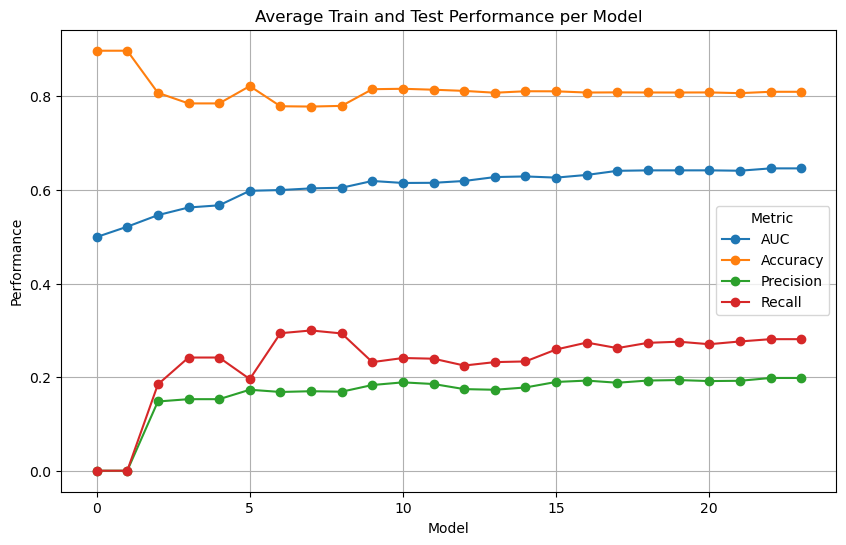

In [16]:
#| echo: false
average_df = results_df.groupby(level=0, axis=1).mean()
plt.figure(figsize=(10, 6))

for metric in average_df.columns:
    plt.plot(average_df.index, average_df[metric], marker='o', label=metric)

plt.title('Average Train and Test Performance per Model')
plt.xlabel('Model')
plt.ylabel('Performance')
plt.legend(title='Metric')
plt.grid(True)
plt.show()

### Nonlinear model

Informative non-linear terms were found using scikit-learn tools. First, the interaction and transformation terms of order 2 were created and scaled. Then, a ridge regression model was developed for a range of hyper parameter and threshold values. C-value and threshold were tuned in tandem to optimize performance. For each C-value-threshold combination, accuracy, recall, precision, and AUC scores were again calculated using cross_val_predict from the model selection scikit-learn library.

When determining ideal hypermeter and threshold values, I addressed the precision-recall tradeoff by enforcing a minimum recall value of 0.02, and then optimizing the results according to both accuracy and precision. Each optimization returned the same c-value-threshold combination: threshold = 0.5, C = 100. The tuned ridge model was created using these values, resulting in the following test performances:

In [19]:
#| echo: false
tuned_model = LogisticRegression(penalty='l2', C = 100)

poly = PolynomialFeatures(2, include_bias=False)
    

X_train_poly = pd.DataFrame(poly.fit_transform(X_train))
X_test_poly = pd.DataFrame(poly.fit_transform(X_test))
X_train_poly.columns = poly.get_feature_names_out()
X_test_poly.columns = poly.get_feature_names_out()

scaler = StandardScaler()
scaler.fit(X_train_poly)
X_train_scaled = scaler.transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

tuned_model.fit(X_train_scaled, y_train)
y_pred_probs = tuned_model.predict_proba(X_test_scaled)[:,1]
y_pred_probs_train = tuned_model.predict_proba(X_train_scaled)[:,1]

print('Test accuracy:', accuracy_score(y_test, y_pred_probs > 0.5))
print('Test precision:', precision_score(y_test, y_pred_probs > 0.5))
print('Test recall:', recall_score(y_test, y_pred_probs > 0.5))
print('Test AUC:', roc_auc_score(y_test, y_pred_probs))

Test accuracy: 0.8986731001206273
Test precision: 0.6190476190476191
Test recall: 0.05058365758754864
Test AUC: 0.6561515241402174


### Interpretation

Below are the mean of train and test performances between M23, the linear model with all predictors, and the tuned model.

In [22]:
#| echo: false
metrics = ['Model','Accuracy', 'Recall', 'Precision','AUC']


compare_scores_df = pd.DataFrame(columns=metrics)


acc = .5*(accuracy_score(y_test, y_pred_probs > 0.5) + accuracy_score(y_train, y_pred_probs_train > 0.5))
rec = .5*(recall_score(y_test, y_pred_probs > 0.5) + recall_score(y_train, y_pred_probs_train > 0.5))
prec = .5*(precision_score(y_test, y_pred_probs > 0.5) + precision_score(y_train, y_pred_probs_train > 0.5))
auc = .5*(roc_auc_score(y_test, y_pred_probs) + roc_auc_score(y_train, y_pred_probs_train))


acc23 = results_df.loc[23.0,'Accuracy'].mean()
rec23 =results_df.loc[23.0,'Recall'].mean()
prec23 = results_df.loc[23.0,'Precision'].mean()
auc23 = results_df.loc[23.0,'AUC'].mean()

compare_scores_df.Model = ['M23','Regularized Ridge']

compare_scores_df.loc[0, 'Accuracy'] = acc23
compare_scores_df.loc[0, 'Recall'] = rec23
compare_scores_df.loc[0, 'Precision'] = prec23
compare_scores_df.loc[0, 'AUC'] = auc23

compare_scores_df.loc[1, 'Accuracy'] = acc
compare_scores_df.loc[1, 'Recall'] = rec
compare_scores_df.loc[1, 'Precision'] = prec
compare_scores_df.loc[1, 'AUC'] = auc

compare_scores_df


,Model,Accuracy,Recall,Precision,AUC
0,M23,0.809761,0.281126,0.198192,0.64609
1,Regularized Ridge,0.900281,0.051504,0.682763,0.692922


Accuracy, precision, and AUC are significantly higher in the regularized model, indicating that regularized, nonlinear coefficients may be more informative than their linear counterparts. Recall decreased significantly from 0.28 to 0.05 after regularization, although this is not necessarily problematic given the improvements in all other metrics and the benefits of a slightly more conservative model for a nuanced classification task such as this.

The tuned model uses 324 predictors - all polynomial terms of order 2 of the 24 original predictors. Coefficients with the five highest absolute values were found:

In [25]:
#| echo: false
tuned_model.coef_.shape # 324 predictors total
cols = poly.get_feature_names_out()
coefs = tuned_model.coef_[0]

coefs_df = pd.DataFrame({'coef name': cols, 'coef abs val': np.abs(coefs)}).sort_values(by=['coef abs val'], ascending=False)

coefs_df.head(5)

,coef name,coef abs val
171,HDI_Score^2,1.582037
102,Liberal_Score political_behavior_process,1.290309
170,Egalitarian_Score region_South America,1.118380
118,Participatory_Score stateviolence,1.110675
52,protesterviolence Deliberative_Score,1.089518


The tuned model shrank 31 coefficients to zero:

In [27]:
#| echo: false
coefs_df.loc[coefs_df['coef abs val'] == 0,:]

,coef name,coef abs val
317,region_MENA region_South America,0.0
316,region_MENA region_Oceania,0.0
315,region_MENA region_North America,0.0
306,region_Central America region_North America,0.0
319,region_North America region_Oceania,0.0
313,region_Europe region_South America,0.0
312,region_Europe region_Oceania,0.0
311,region_Europe region_North America,0.0
320,region_North America region_South America,0.0
310,region_Europe region_MENA,0.0


HDI_Score, democracy indices (especially participatory score interations with protester demands), protester demands, and state violence appear frequently in the top 25 coefficients in magnitude.

In [29]:
#| echo: false
print('Names of the 25 highest predictors in absolute value:')
coefs_df.head(25)['coef name']

Names of the 25 highest predictors in absolute value:


171                                       HDI_Score^2
102          Liberal_Score political_behavior_process
170            Egalitarian_Score region_South America
118                 Participatory_Score stateviolence
52               protesterviolence Deliberative_Score
152           Deliberative_Score region_South America
89                        Electoral_Score region_MENA
120               Participatory_Score land_farm_issue
134                              Deliberative_Score^2
103          Liberal_Score price_increases_tax_policy
86                        Electoral_Score region_Asia
182                  HDI_Score region_Central America
98                        Liberal_Score stateviolence
147         Deliberative_Score region_Central America
93                                    Liberal_Score^2
156              Egalitarian_Score labor_wage_dispute
179                     HDI_Score social_restrictions
49                  protesterviolence Electoral_Score
121              Participato

Looking at predictor correlations with success confirms the importance of certain predictors. Democracy index scores are close in range to each other, with electoral, liberal, and participatory indices being the highest. Among protester demands, political behavior/process, labor wage dispute, land/farm issue, and price increases/tax policy are the most correlated with success. 

In [31]:
#| echo: false
print("Predictors sorted by magnitude of correlation with 'success':")
np.abs(train.corr().success).sort_values(ascending=False)[1:]

Predictors sorted by magnitude of correlation with 'success':


political_behavior_process    0.086837
labor_wage_dispute            0.065229
region_Europe                 0.062066
land_farm_issue               0.057926
stateviolence                 0.057121
region_Oceania                0.051206
HDI_Score                     0.049437
price_increases_tax_policy    0.048556
region_Asia                   0.047775
region_Africa                 0.045756
Egalitarian_Score             0.044479
Liberal_Score                 0.033987
Participatory_Score           0.032724
Electoral_Score               0.030034
Deliberative_Score            0.025421
protesterviolence             0.019394
region_MENA                   0.019220
social_restrictions           0.016452
removal_of_politician         0.011684
region_Central_America        0.011567
region_North_America          0.010433
region_South_America          0.006568
Year                          0.006459
police_brutality              0.003269
Name: success, dtype: float64

#### Interpretation

Nonlinearities:

24 out of 25 most influential coefficients in the regularized model are nonlinear, 21 of them being interaction terms, 17 interactions being between some democracy index and either protester demand or region. The improvements in average test and train perofrmance of this model indicates that democracy indices are thus informative in relation to protest nature and region.

The region_South_America appears twice in the top 6 nonlinear model coefficients, although has the third lowest standalone correlation with success. This indicates that region itself is not so informative, but becomes informative in interactions with other predictors. Performing a model for each region with the same predictors may provide insight into the regional trends in the role of democracy indices and protester demands on protest success. However, region_Europe, region_Oceania, region_Asia, and region_Africa are among the top 50% predictors in standalone correlation, despite only South America, Asia, MENA, and Central America being present in the top 25 nonlinear model coefficients. This indicates nonlinearity in the regional impacts on protest success. Furthermore, the regions of Europe, Oceania, Asia, and Africa may be correlated with more informative predictors, such as protester demands or democracy indices; this discrepancies may be explained by such multicollinearities.

28 out of 31 zero coefficients are the interaction terms among and between regions. This is intuitive, since regions are mutually exclusive, and does not indicate that regions are less informative given the magnitude of their interactions with non-regional predictors.


Examining the lowest non-zero coefficients provies more insight to the least informative coefficients. Below are the 20 lowest non-zero coefficients.

In [33]:
coefs_df1 = pd.DataFrame({'coef name': cols, 'coef abs val': np.abs(coefs), 'coef': coefs}).sort_values(by=['coef abs val'], ascending=False)

#coefs_df1.head(20)

coefs_df1.loc[coefs_df1['coef abs val'] != 0,:].tail(20)

,coef name,coef abs val,coef
24,Year^2,0.011098,0.011098
6,Egalitarian_Score,0.009989,-0.009989
23,region_South America,0.009186,0.009186
323,region_South America^2,0.009186,0.009186
223,land_farm_issue removal_of_politician,0.008709,0.008709
257,political_behavior_process region_South America,0.008608,-0.008608
33,Year labor_wage_dispute,0.008049,-0.008049
65,protesterviolence region_Central America,0.007698,-0.007698
61,protesterviolence removal_of_politician,0.006877,0.006877
42,Year region_Central America,0.006574,0.006574


Non-interaction terms: region_South_America, Egalitarian_Score, Year, price_increases_tax_policy.

All non-interaction terms above are present in interaction coefficients in the top 20 model coefficients, except for year. In fact, year is not present in any form among the top 20 model coefficients, and is also the second least correlated with success, indicating its non-informativeness to protest success. Although year is not informative in any transformation terms of order 2, it may be informative in a model of order 3, e.g., the interaction between Participation_Score, stateviolence, and year may be informative, despite interactions between year and either one of participation score and state violence not being informative in this model.

## 6) Inference

Based on the coefficient analysis above, a logistic regression model was created with predictors:

- avg_dem_score = mean of 3 highest importance demoracy indices: liberal, participatory, and egalitarian scores
- HDI score
- protester and state violence
- regions
- 4 most important protester demands: political behavior/process, labor wage dispute, land/farm issue, and price increases/tax policy

With all linear terms and interactions between:

- HDI_Score and stateviolence, protesterviolence
- region and avg_dem_score



In [37]:
#| echo:false
train['avg_dem_score'] = train[['Liberal_Score','Participatory_Score','Egalitarian_Score']].mean(axis=1)
test['avg_dem_score'] = test[['Liberal_Score','Participatory_Score','Egalitarian_Score']].mean(axis=1)
model = smf.logit('success ~ HDI_Score*(stateviolence + protesterviolence) + political_behavior_process + labor_wage_dispute + land_farm_issue + price_increases_tax_policy + (region_South_America + region_Europe + region_North_America + region_Central_America + region_MENA + region_Oceania)*avg_dem_score', data=train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.313844
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                 9948
Model:                          Logit   Df Residuals:                     9925
Method:                           MLE   Df Model:                           22
Date:                Sun, 16 Mar 2025   Pseudo R-squ.:                 0.04504
Time:                        23:12:36   Log-Likelihood:                -3122.1
converged:                       True   LL-Null:                       -3269.4
Covariance Type:            nonrobust   LLR p-value:                 1.587e-49
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -1.7660      0.263     -6.710      0.000      -2.282      -1.250
region_South_America[T.True]                    -0.3360      0.450     -0.746      0.456      -1.218       0.546
region_Europe[T.True]                            0.4598      0.231      1.991      0.047       0.007       0.912
region_North_America[T.True]                    -0.5820      0.389     -1.495      0.135      -1.345       0.181
region_Central_America[T.True]                  -1.4085      0.479     -2.938      0.003      -2.348      -0.469
region_MENA[T.True]                             -0.3551      0.283     -1.255      0.209      -0.910       0.199
region_Oceania[T.True]                           3.6372      5.365      0.678      0.498      -6.879      14.153
HDI_Score                                       -0.2383      0.395     -0.603      0.546      -1.012       0.536
stateviolence                                   -1.8288      0.477     -3.832      0.000      -2.764      -0.893
protesterviolence                               -1.0240      0.321     -3.187      0.001      -1.654      -0.394
HDI_Score:stateviolence                          1.8410      0.708      2.600      0.009       0.453       3.229
HDI_Score:protesterviolence                      1.4898      0.486      3.063      0.002       0.537       2.443
political_behavior_process                      -0.2335      0.078     -2.985      0.003      -0.387      -0.080
labor_wage_dispute                               0.5751      0.092      6.249      0.000       0.395       0.755
land_farm_issue                                  0.7105      0.143      4.962      0.000       0.430       0.991
price_increases_tax_policy                       0.5068      0.104      4.877      0.000       0.303       0.710
avg_dem_score                                    0.5627      0.336      1.672      0.094      -0.097       1.222
region_South_America[T.True]:avg_dem_score      -0.4625      0.853     -0.542      0.588      -2.134       1.209
region_Europe[T.True]:avg_dem_score             -2.3409      0.466     -5.024      0.000      -3.254      -1.428
region_North_America[T.True]:avg_dem_score       0.2766      1.002      0.276      0.782      -1.687       2.240
region_Central_America[T.True]:avg_dem_score     1.7145      1.074      1.596      0.110      -0.390       3.819
region_MENA[T.True]:avg_dem_score               -0.2191      1.276     -0.172      0.864      -2.721       2.283
region_Oceania[T.True]:avg_dem_score            -6.7120     16.708     -0.402      0.688     -39.459      26.035
================================================================================================================
"""


**Significant predictors**:

The following predictors have p-values < 0.05. All others do not, indicating statistical insignificance at a significance level of 95%.

- region Europe

- region Central America

- protester violence

- state violence

- HDI score : protester violence

- HDI score : state violence

- political behavior / process

- labor wage dispute

- land farm issue

- price increases / tax policy

- region Europe : avg dem score


In [39]:
#| echo:false
print('Changes in odds of protest success based on linear terms:')

print('Protest occurring in Europe:', np.round((np.exp(model.params['region_Europe[T.True]']) - 1) * 100, 2), '%')
print('Protest occurring in Central America:', np.round((np.exp(model.params['region_Central_America[T.True]']) - 1) * 100, 2), '%')

print('Occurrence of protester violence:', np.round((np.exp(model.params['protesterviolence']) - 1) * 100, 2), '%')
print('Occurrence of state violence:', np.round((np.exp(model.params['stateviolence']) - 1) * 100, 2), '%')

print('Political behavior/process among protester demands:', np.round((np.exp(model.params['political_behavior_process']) - 1) * 100, 2), '%')
print('Land/farm issue among protester demands:', np.round((np.exp(model.params['land_farm_issue']) - 1) * 100, 2), '%')
print('Labor wage dispute among protester demands:', np.round((np.exp(model.params['labor_wage_dispute']) - 1) * 100, 2), '%')
print('Price increases/tax policy among protester demands:', np.round((np.exp(model.params['price_increases_tax_policy']) - 1) * 100, 2), '%')

Changes in odds of protest success based on linear terms:
Protest occurring in Europe: 58.37 %
Protest occurring in Central America: -75.55 %
Occurrence of protester violence: -64.08 %
Occurrence of state violence: -83.94 %
Political behavior/process among protester demands: -20.82 %
Land/farm issue among protester demands: 103.49 %
Labor wage dispute among protester demands: 77.73 %
Price increases/tax policy among protester demands: 66.0 %


In [40]:
#| echo:false
print('Changes in odds of protest success based on interaction terms:')
print('Unit increase in HDI score in presence of protester violence:', np.round((np.exp(model.params['HDI_Score:protesterviolence']) - 1) * 100, 2), '%')
print('Unit increase in HDI score in presence of state violence:', np.round((np.exp(model.params['HDI_Score:stateviolence']) - 1) * 100, 2), '%')
print('Unit increase in avg dem score in Europe:', np.round((np.exp(model.params['region_Europe[T.True]:avg_dem_score']) - 1) * 100, 2), '%')

Changes in odds of protest success based on interaction terms:
Unit increase in HDI score in presence of protester violence: 343.62 %
Unit increase in HDI score in presence of state violence: 530.28 %
Unit increase in avg dem score in Europe: -90.38 %


To determine the explanatory power of the final model, the ROC curve and AUC was calculated using the roc_curve and roc_auc_score scikit-learn tools. The AUC score of ~66% (66.18% test, 65.91% train) indicates that the model can distinguish between classes, but not exceptionally well. The linear model M23 using all predictors has an AUC score of ~64%, and the regularized ridge model has an AUC score of ~69%. Despite this, the model maintains a high accuracy of ~90%, which is equal to the regularized ridge model's accuracy and a 10% increase from the M23 model's accuracy.

In [42]:
#| echo: false

y_pred_probs = model.predict(test)
y_pred_probs_train = model.predict(train)

metrics = ['Data','Accuracy','AUC']


scores_df = pd.DataFrame(columns=metrics)

scores_df.loc[0,'Data'] = 'Test'
scores_df.loc[1,'Data'] = 'Train'

scores_df.loc[0,'Accuracy'] = accuracy_score(test.success, y_pred_probs > 0.5)
scores_df.loc[1,'Accuracy'] = accuracy_score(train.success, y_pred_probs_train > 0.5)

scores_df.loc[0,'AUC'] = roc_auc_score(test.success, y_pred_probs)
scores_df.loc[1,'AUC'] = roc_auc_score(train.success, y_pred_probs_train)

scores_df = scores_df.reset_index(drop=True)
scores_df


,Data,Accuracy,AUC
0,Test,0.896663,0.661833
1,Train,0.898573,0.659126


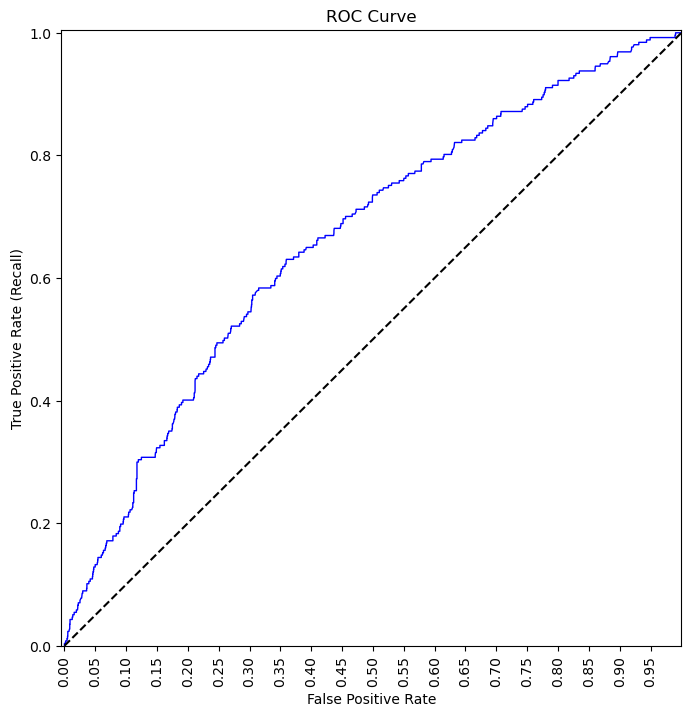

In [43]:
#| echo: false
fpr, tpr, thres = roc_curve(test.success, y_pred_probs)

plt.figure(figsize=(8,8))
plt.title('ROC Curve')
plt.plot(fpr, tpr, linewidth=1,color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0,1, 0.05), rotation=90)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")        
plt.show()

## 7) Recommendation to Stakeholders

**Action items**

1. Many political science studies predict violence using region, economic indices, and democracy indices. Given the importance of democracy indices in protest outcomes, and interactions between democracy indices and violence, protest demands and outcomes may bear significant implications to civil violence as a whole. The significance of protester demands in protest success suggests that certain citizen demands may be more likely to eventually lead to violence.

2. Major datasets that document outbreaks of violence and protests should take citizen demands into account.

3. In a study with a larger dataset, interactions above the polynomial order 2 transformations could be analyzed to determine whether Year is influential. As mentioned in the prediction section, year was not informative in any interactions with one other predictor, although it may be informative in interactions with an informative interaction term, such as HDI_Score : stateviolence. 


**Limitations & suggestions**

1. Limited data size - 9948 training observations, 2487 training observations

2. Uneven distribution of regions - mostly from Europe, Africa, Asia

3. Collect more data, create an individual model with the same predictors for EACH region, then compare coefficient values and significances to draw regional comparisons

4. Further analysis of mid-range interaction terms coefficients. Only the top 25 coefficients in absolute value of the regularized model were used to select predictors for the final model.


## 8) Conclusion


Democracy indices, protester demands, and regional interactions are significant predictors of protest success. Interaction effects, particularly between democracy indices and protester demands or regions, are notably influential, highlighting the complex and nonlinear relationships underlying political unrest. Positive correlation between HDI scores and protest success, especially in the context of violence at the citizen and state level, further demonstrates the socio-economic dimension of successful citizen mobilization. While regions such as South America show strong interaction effects despite low standalone correlations, others such as Europe display complex relationships that warrant regional analysis. The non-informativeness of 'year' suggests that temporal factors may not significantly influence protest outcomes at polynomial order 2, as used in this model. Despite limitations in data size and distribution, the improvement in model performance underscores the importance of considering protester demands when analyzing protest, and protest when analyzing political unrest and violence on a large scale.